# Comparison of deconvolution based on SPM12 *Parametrical Empirical Bayes* (PEB) approach vs *ridge regression*

In [1]:
import numpy as np
from scipy import io
from scipy.stats import pearsonr, gamma
from scipy.signal import detrend
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from tqdm import trange
from bold_deconvolution import ridge_regress_deconvolution, compute_xb_Hxb

# Canonical HRF in SPM12

In [2]:
# Download HRF created by spm_hrf function
data_hrf = io.loadmat('../examples/SPM_HRFs.mat')

In [3]:
# Downsampled (scan resolution)
TR = 2   # Time repetition = 2 s
dt = TR
t = np.arange(0, 32 + dt, dt)
hrf = gamma.pdf(t, 6) - gamma.pdf(t, 16) / 6
hrf = hrf / np.sum(hrf)

In [4]:
# Upsampled (microtime resolution)
TR = 2    # Time repetition = 2 s
NT = 16   # Microtime resolution = 16 (by default in SPM12)
dt = TR / NT
t = np.arange(0, 32 + dt, dt)
hrf_upampled = gamma.pdf(t, 6) - gamma.pdf(t, NT) / 6
hrf_upampled = hrf_upampled / np.sum(hrf_upampled)

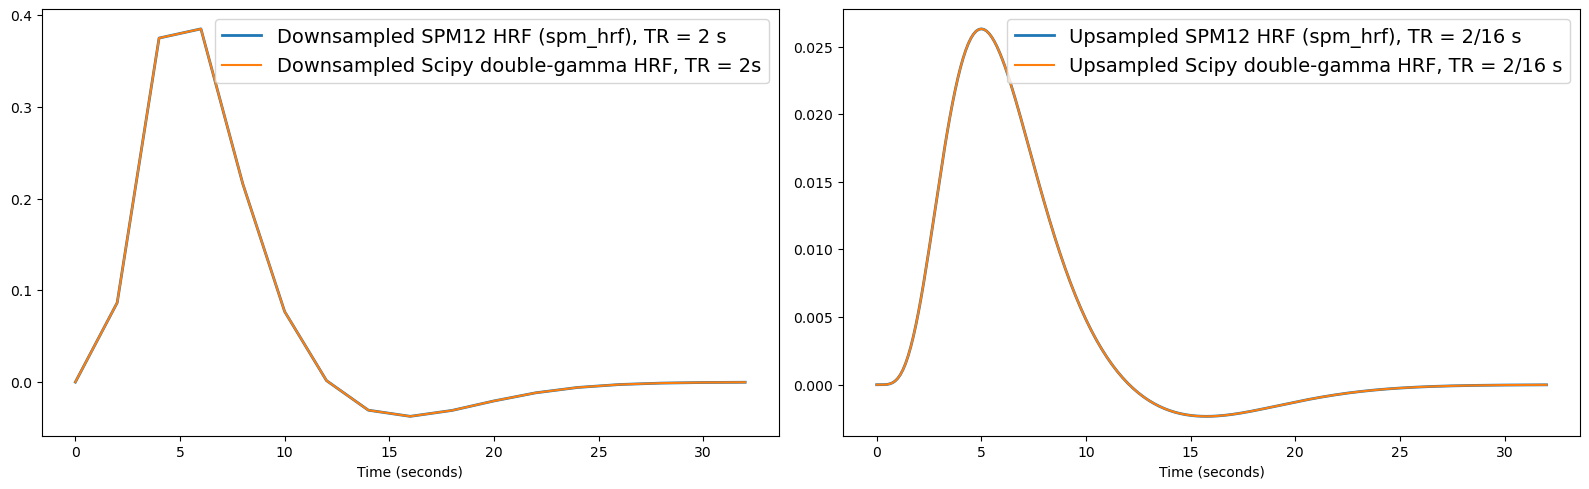

In [5]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(range(0,34,2),data_hrf['spm_hrf_downsampled'], lw = 2, label = 'Downsampled SPM12 HRF (spm_hrf), TR = 2 s')
plt.plot(range(0,34,2),hrf, label = 'Downsampled Scipy double-gamma HRF, TR = 2s')
plt.xlabel('Time (seconds)')
plt.legend(fontsize = 14)

plt.subplot(1,2,2)
plt.plot(data_hrf['spm_hrf_upsampled'], lw = 2, label = 'Upsampled SPM12 HRF (spm_hrf), TR = 2/16 s')
plt.plot(hrf_upampled, 
        label = 'Upsampled Scipy double-gamma HRF, TR = 2/16 s')
plt.xlabel('Time (seconds)')
plt.xticks(range(0,257,40), [0,5,10,15,20,25,30])
plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

# Download BOLD time-series and PPI term calculated by SPM12 (spm_peb_ppi.m)

### Select data below

In [6]:
# Simulated BLOCK design, SNR = 0.4, TR = 2s

data = io.loadmat('../examples/01_BLOCK_DESIGN_SF_[1.00]_SNR_[0.40]/Sub_1_ROI_1.mat')
BOLD = data['preproc_BOLD_signal']

# Repetition time [s]
TR = 2

# Preprocessed BOLD time-series length
N = len(data['preproc_BOLD_signal'])

# Microtime resolution
NT = 16

In [45]:
# Simulated EVENT-RELATED design, SNR = 0.4, TR = 2s
data = io.loadmat('../examples/02_EVENT_RELATED_DESIGN_SF_[1.00]_SNR_[0.40]/Sub_01_ROI_01.mat')
BOLD = data['preproc_BOLD_signal']

# Repetition time [s]
TR = 2

# Preprocessed BOLD time-series length
N = len(data['preproc_BOLD_signal'])

# Microtime resolution
NT = 16

In [42]:
# Empirical BLOCK design, HCP Working Memory, TR = 0.72
data = io.loadmat('../examples/03_BLOCK_DESIGN_HCP_WM/Sub_01_ROI_01.mat')
BOLD = data['preproc_BOLD_signal']

# Repetition time [s]
TR = 0.72

# Preprocessed BOLD time-series length
N = len(data['preproc_BOLD_signal'])

# Microtime resolution
NT = 16

In [47]:
# Empirical EVENT-RELATED design, CNP Stop-signal task, TR = 0.72
data = io.loadmat('../examples/04_EVENT_RELATED_DESIGN_CNP_SST/Sub_01_ROI_01.mat')
BOLD = data['preproc_BOLD_signal']

# Repetition time [s]
TR = 2

# Preprocessed BOLD time-series length
N = len(data['preproc_BOLD_signal'])

# Microtime resolution
NT = 34

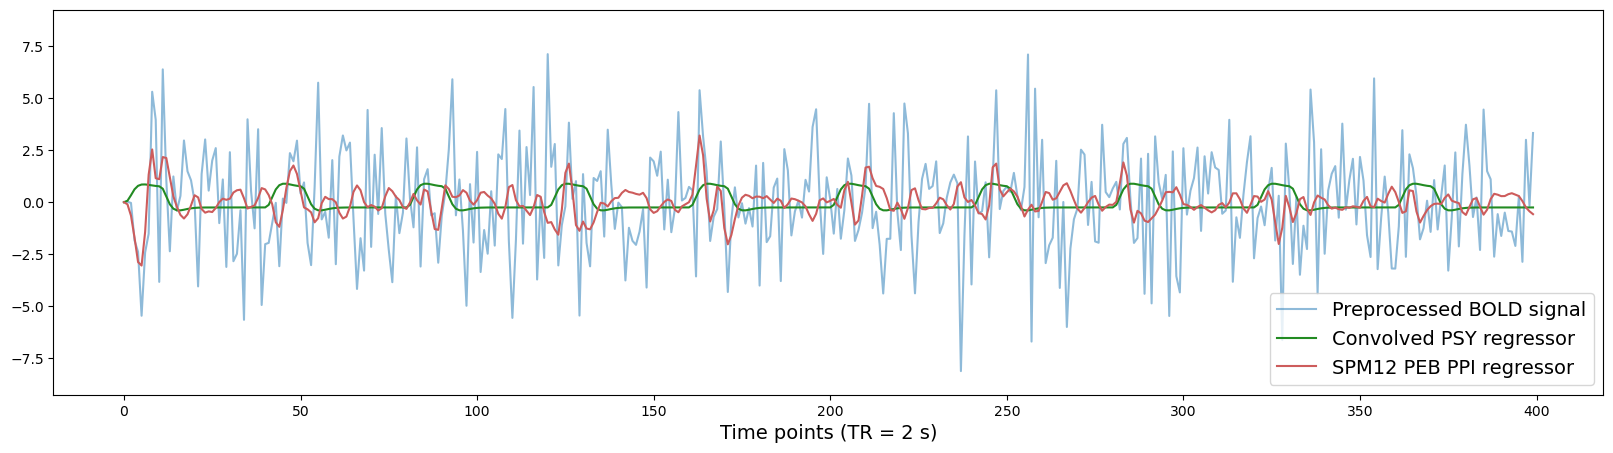

In [7]:
# Plot 
plt.figure(figsize=(20, 5))
plt.plot(data['preproc_BOLD_signal'], label = 'Preprocessed BOLD signal', alpha = 0.5)
plt.plot(data['psy_convolved'], c = 'forestgreen', label = 'Convolved PSY regressor')
plt.plot(data['spm_ppi'], c = 'indianred', label = 'SPM12 PEB PPI regressor')
plt.legend(fontsize = 14)
plt.ylim(-1.3*np.max(data['preproc_BOLD_signal']), 1.3*np.max(data['preproc_BOLD_signal']))
plt.xlabel('Time points (TR = 2 s)', fontsize = 14)
plt.show()

# Create discrete cosine functions as in spm_dctmtx.m

In [8]:
def dctmtx_numpy_vect(N: int, K: int) -> np.ndarray:
    n = np.arange(N)
    C = np.zeros((N, K))
    C[:, 0] = 1 / np.sqrt(N)
    k = np.arange(1, K)
    C[:, 1:K] = np.sqrt(2 / N) * np.cos(np.pi * (2 * n[:, np.newaxis]) * k / (2 * N))
    return C

In [9]:
# Create cosine basis set
xb = dctmtx_numpy_vect(NT*N+128,N)

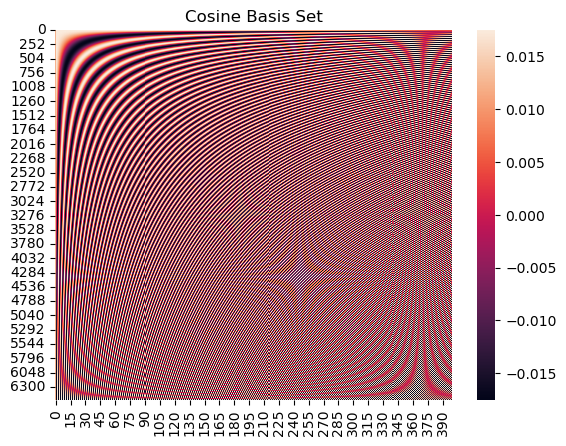

In [10]:
sns.heatmap(xb);
plt.title('Cosine Basis Set');

# Convolve cosine basis set with canonical HRF

In [11]:
# Create HRF with specified microtime resolution
dt = TR / NT
t = np.arange(0, 32 + dt, dt)
hrf = gamma.pdf(t, 6) - gamma.pdf(t, NT) / 6
hrf = hrf / np.sum(hrf)

In [12]:
k = np.arange(0, N * NT, NT)  # Microtime to scan time indices

Hxb = np.zeros((N, N))
for i in range(N):
        Hx = np.convolve(xb[:, i], hrf, mode='full')
        Hxb[:, i] = Hx[k + 128]
xb = xb[128:, :]

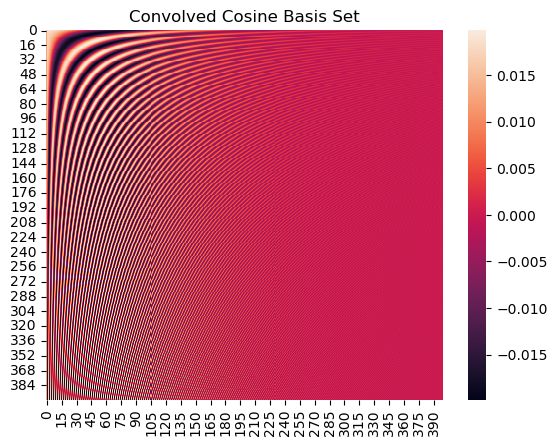

In [13]:
sns.heatmap(Hxb);
plt.title('Convolved Cosine Basis Set');

# Perform ridge regression

In [14]:
# Alpha = 0 (ridge regression reduces to ordinary least-squares (OLS) method)
reg_alpha_0 = Ridge(alpha=0,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_0.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=0, fit_intercept=False, max_iter=1000, solver='lsqr')

In [15]:
# Alpha = 1
reg_alpha_1 = Ridge(alpha=1,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_1.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=1, fit_intercept=False, max_iter=1000, solver='lsqr')

In [16]:
# Alpha = 0.01
reg_alpha_01 = Ridge(alpha=0.01,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_01.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=0.01, fit_intercept=False, max_iter=1000, solver='lsqr')

In [17]:
# Alpha = 0.005
reg_alpha_005 = Ridge(alpha=0.005,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_005.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=0.005, fit_intercept=False, max_iter=1000, solver='lsqr')

# Recover neuronal signal 

In [18]:
neuronal_alpha_0 = xb @ reg_alpha_0.coef_[0,:N]
neuronal_alpha_1 = xb @ reg_alpha_1.coef_[0,:N]
neuronal_alpha_01 = xb @ reg_alpha_01.coef_[0,:N]
neuronal_alpha_005 = xb @ reg_alpha_005.coef_[0,:N]

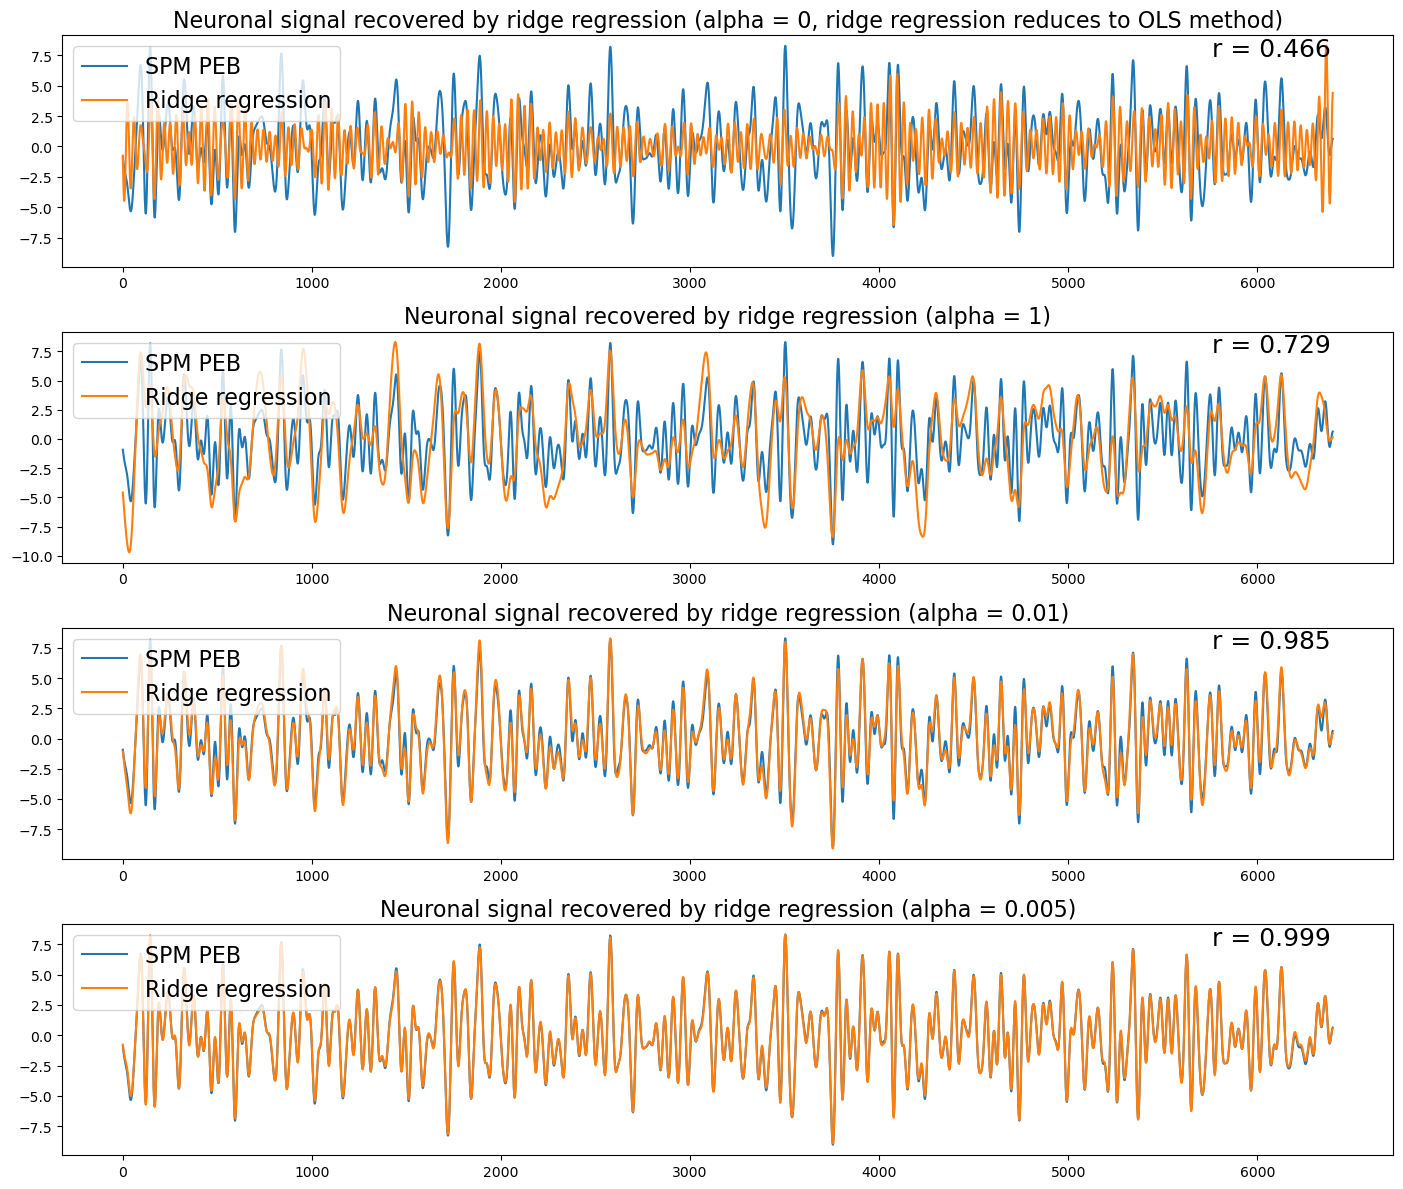

In [19]:
plt.figure(figsize=(14, 12))

plt.subplot(4,1,1)
plt.title('Neuronal signal recovered by ridge regression (alpha = 0, ridge regression reduces to OLS method)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_0/np.max(neuronal_alpha_0)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_0.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)

plt.subplot(4,1,2)
plt.title('Neuronal signal recovered by ridge regression (alpha = 1)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_1/np.max(neuronal_alpha_1)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_1.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)


plt.subplot(4,1,3)
plt.title('Neuronal signal recovered by ridge regression (alpha = 0.01)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_01/np.max(neuronal_alpha_01)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_01.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)


plt.subplot(4,1,4)
plt.title('Neuronal signal recovered by ridge regression (alpha = 0.005)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_005/np.max(neuronal_alpha_005)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_005.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)

plt.tight_layout()
plt.show()

## Correlation between neuronal signals recovered by SPM PEB and ridge regression depending on regularization parameter

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 195.46it/s]


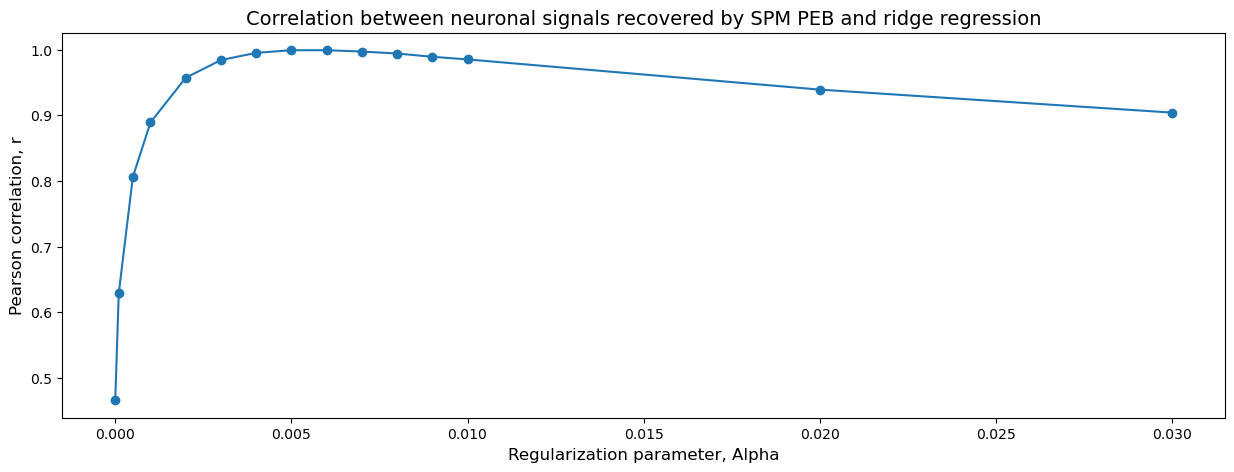

In [20]:
A = []
B = []
alpha_range = [0, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03]
for i in trange(len(alpha_range)):
    reg = Ridge(alpha=alpha_range[i],solver='lsqr',fit_intercept=False,max_iter=1000)
    reg.fit(Hxb,data['preproc_BOLD_signal'])
    neuronal = xb @ reg.coef_[0,:N]
    #C = np.linalg.solve(Hxb.T @ Hxb + alpha_range[i] * np.eye(N), Hxb.T @ BOLD)
    #neuronal = xb @ C
    
    A.append(alpha_range[i])
    B.append(round(pearsonr(np.squeeze(np.asarray(neuronal.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3))

plt.figure(figsize=(15, 5))
plt.plot(A,B)
plt.scatter(A,B)
plt.title('Correlation between neuronal signals recovered by SPM PEB and ridge regression', fontsize = 14)
plt.xlabel('Regularization parameter, Alpha', fontsize = 12)
plt.ylabel('Pearson correlation, r', fontsize = 12)
plt.show()

# Neuronal PPI

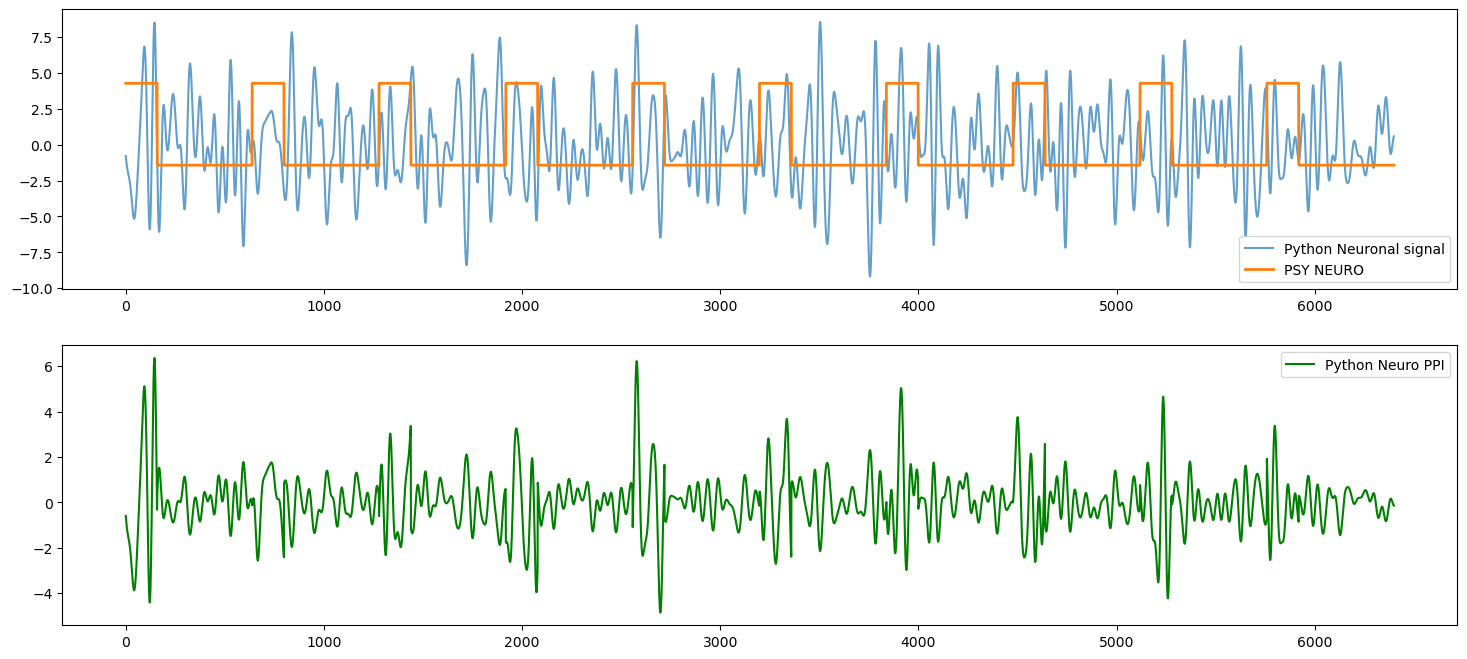

In [21]:
# Detrend PSY
psy_detrended = detrend(data['psy_neuro'],axis = 0, type = 'constant')
ppi = neuronal_alpha_005.reshape(-1,1) * psy_detrended

plt.figure(figsize=(18, 8))
plt.subplot(2,1,1)
plt.plot(neuronal_alpha_005,label = 'Python Neuronal signal', alpha = 0.7)
plt.plot(psy_detrended/np.max(psy_detrended)*np.max(neuronal_alpha_005)/2, label = 'PSY NEURO', lw = 2)
plt.legend()

plt.subplot(2,1,2)
plt.plot(ppi, label = 'Python Neuro PPI', c= 'green')
plt.legend()

plt.show()

# Convolution of the neuonal PPI regressor

In [22]:
ppi_conv = np.convolve(ppi[:,0], hrf)[k]

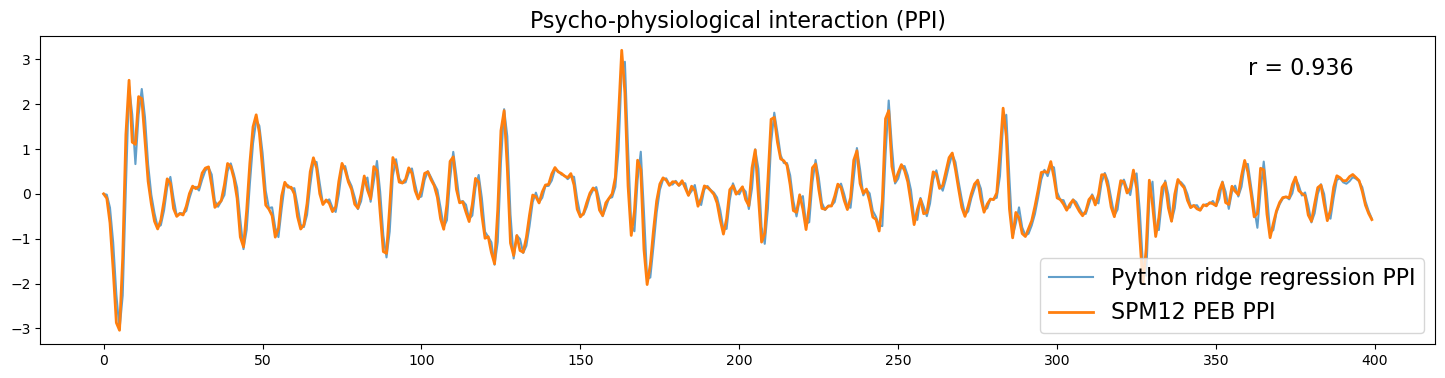

In [23]:
plt.figure(figsize=(18, 4))

plt.title(f'Psycho-physiological interaction (PPI)', fontsize=16)
plt.plot(ppi_conv, label = 'Python ridge regression PPI', alpha = 0.7)
plt.plot(data['spm_ppi'], label = 'SPM12 PEB PPI', lw = 2)
plt.text(N*0.9, np.max(ppi_conv)*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(ppi_conv.reshape(-1,1))),np.squeeze(np.asarray(data['spm_ppi'].reshape(-1,1))))[0],3)), fontsize=16)
plt.legend(fontsize=16, loc = 4)

plt.show()

# Use *ridge_regress_deconvolution.py* function for deconvolution

Text(5760.0, 7.458723359176885, 'r = 0.9992')

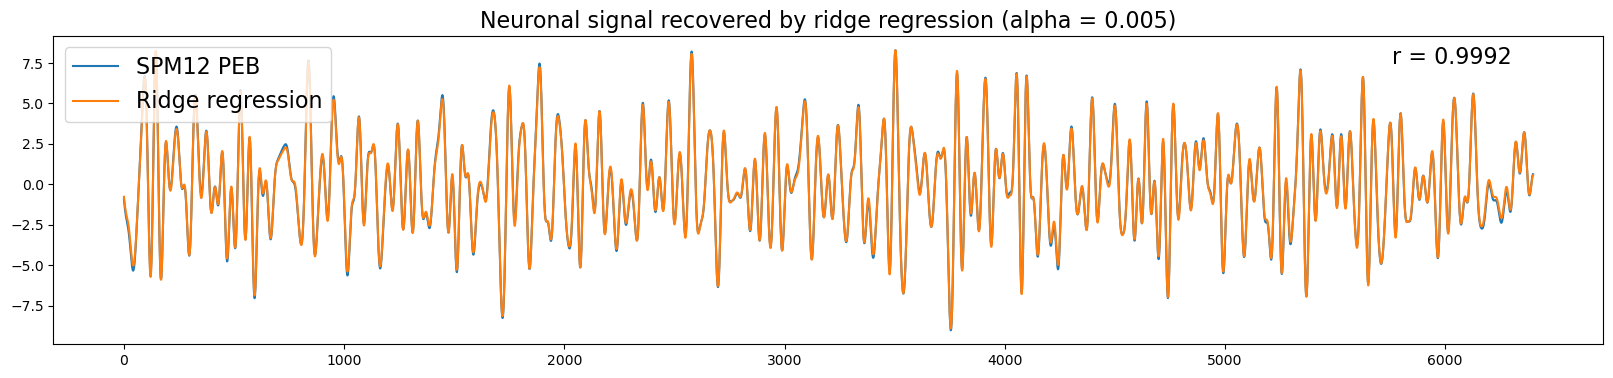

In [24]:
alpha = 0.005
neuronal = ridge_regress_deconvolution(BOLD, TR, alpha, NT)
spm_neuro = data['spm_phys_neuro'].squeeze()

plt.figure(figsize=(20, 4))
plt.title(f'Neuronal signal recovered by ridge regression (alpha = {alpha})',
                  fontsize=16)
plt.plot(spm_neuro, label='SPM12 PEB')
plt.plot(neuronal / np.max(neuronal) * np.max(spm_neuro), label='Ridge regression')
plt.legend(loc=2, fontsize=16)
r = pearsonr(neuronal, spm_neuro).correlation
plt.text(len(neuronal)* 0.9, np.max(spm_neuro) * 0.9, 'r = ' + str(round(r, 4)), fontsize=16)

In [25]:
# If we deconvolve multiple BOLD-time series from the same session,
# we can precompute cosine basis set to speed up computations 
# (since we are using the same basis set for all time series)
xb, Hxb = compute_xb_Hxb(len(BOLD), NT, TR)

neural_time_series = ridge_regress_deconvolution(BOLD, TR, alpha, NT, xb=xb, Hxb=Hxb)